In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sys.path.insert(0,"../src/")
import SGD
import CostFunctions

sys.path.insert(0,"../../project_1/src/")
from FrankeFunction import *
import stat_tools
import linear_regression

In [2]:
n = 1000                # Number of data points
noise_scale = 0.2      # Size of artificial noise
M = 10                # Number of mini-batches in SGD
n_epochs = 800        # Number of epochs in SGD
learning_rate = 1e-2  # Learning rate of SGD


# Generate data
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y)

# Add standard normal noise:
z = z + noise_scale * np.random.normal(0, 1, len(z))
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)

# Center the response 
z_train_intercept = np.mean(z_train)
z_train = z_train - z_train_intercept
z_test = z_test - z_train_intercept

# Parameters to test
degrees = np.arange(2, 14)
lambdas = np.logspace(-10, 0, 5)

# Store Stochastic Gradient Descent MSE
OLS_MSE_SGD = np.zeros(len(degrees))
Ridge_MSE_SGD = np.zeros([len(degrees), len(lambdas)])

# Store Analytic Solution MSE
OLS_MSE_Analytic = np.zeros(len(degrees))
Ridge_MSE_Analytic = np.zeros([len(degrees), len(lambdas)])

In [3]:
for i, degree in enumerate(degrees):
    
    # Create design matrices
    X_train = linear_regression.design_matrix_2D(x_train, y_train, degree)
    X_test = linear_regression.design_matrix_2D(x_test, y_test, degree)
    
    # Scale design matrix according to the training data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Remove the intercept
    X_train_scaled = X_train_scaled[:,1:]
    X_test_scaled = X_test_scaled[:,1:]
    
    N_predictors = int((degree + 1) * (degree + 2) / 2) - 1 # Don't include intercept
    w_init = np.random.randn(N_predictors) # Random initial weights
    
    # Solve for optimal weights using OLS Cost function
    w_OLS_Analytic = linear_regression.OLS_SVD_2D(X_train_scaled, z_train)
    
    w_OLS_SGD = SGD.ADAgrad(
        X_train_scaled, 
        z_train, 
        M, 
        w_init, 
        n_epochs, 
        learning_rate, 
        CostFunctions.OLS_cost_gradient)
    
    # Compute the MSE
    OLS_MSE_SGD[i] = stat_tools.MSE(z_test, X_test_scaled @ w_OLS_SGD)
    OLS_MSE_Analytic[i] = stat_tools.MSE(z_test, X_test_scaled @ w_OLS_Analytic)
    
    for j, lambd in enumerate(lambdas):
        # Solve for optimal weights using Ridge Cost function
        w_Ridge_Analytic = linear_regression.Ridge_2D(X_train_scaled, z_train, lambd)
        w_Ridge_SGD = SGD.ADAgrad(
            X_train_scaled, 
            z_train, 
            M, 
            w_init, 
            n_epochs, 
            learning_rate, 
            CostFunctions.Ridge_cost_gradient,
            lambd)
        
        # Compute the MSE
        Ridge_MSE_SGD[i,j] = stat_tools.MSE(z_test, X_test_scaled @ w_Ridge_SGD)
        Ridge_MSE_Analytic[i,j] = stat_tools.MSE(z_test, X_test_scaled @ w_Ridge_Analytic)

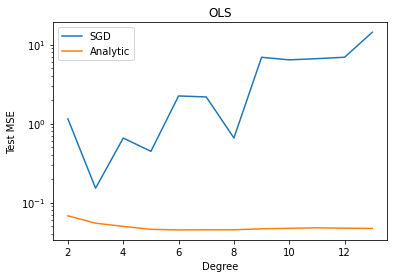

In [4]:
plt.semilogy(degrees, OLS_MSE_SGD, label="SGD")
plt.semilogy(degrees, OLS_MSE_Analytic, label="Analytic")
plt.xlabel("Degree")
plt.ylabel("Test MSE")
plt.title("OLS")
plt.legend()

Text(0.5, 1.0, 'Ridge')

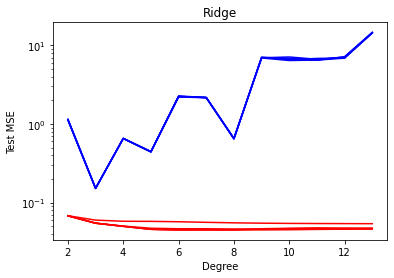

In [5]:
plt.semilogy(degrees, Ridge_MSE_SGD, color="blue")
plt.semilogy(degrees, Ridge_MSE_Analytic, color="red")
plt.xlabel("Degree")
plt.ylabel("Test MSE")
plt.title("Ridge")